In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Import XGBoost and LightGBM
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
# Load the dataset
df = pd.read_csv("../synthetic_data/synthetic_job_data.csv")

df.head()

,title,location,industry,skills,skill_categories,description,min_salary,max_salary,med_salary
0,Entry Level Operations Manager,San Francisco,Manufacturing,"['Risk Management', 'Scrum', 'React', 'Supply ...","['Software Engineering', 'Product & Management...",Exciting opportunity for a Entry Level Operati...,90971.49,136766.40,113868.945
1,Executive Data Scientist,Chicago,Real Estate,"['Marketing Strategy', 'Retail Sales', 'Custom...","['Product & Management', 'Finance', 'Business']",We are seeking a Executive Data Scientist to j...,286322.01,512257.88,399289.945
2,Entry Level Marketing Specialist,San Francisco,Healthcare,"['Real Estate Law', 'Marketing Strategy', 'Cus...",['Business'],Join our growing Healthcare company as a Entry...,69494.95,118199.88,93847.415
3,Entry Level HR Generalist,New York,Healthcare,"['EHR Systems', 'Logistics', 'Healthcare IT', ...","['Design', 'Healthcare', 'Operations']",We are seeking a Entry Level HR Generalist to ...,75259.69,123618.02,99438.855
4,Entry Level Supply Chain Analyst,Chicago,Retail,"['React', 'Investment Banking', 'Equity Resear...","['Software Engineering', 'Finance']",Exciting opportunity for a Entry Level Supply ...,70794.23,106706.12,88750.175


In [3]:
# Combine text features into a single feature
df['text'] = df['title'] + ' ' + df['location'] + ' ' + df['description']


In [4]:
# Define the target variable and features
X = df['text']
y = df['med_salary']

# Split the data into training and testing sets
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [5]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# Fit and transform the training data, transform the testing data
X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)


In [6]:
# Initialize models
ridge = Ridge()
rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
lgbm = LGBMRegressor(random_state=42)

# Initialize models
ridge = Ridge()
rf = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(random_state=42)
lgbm = LGBMRegressor(random_state=42)

# Define hyperparameter grids for each model
ridge_param_grid = {'alpha': [0.1, 1, 10, 100]}
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}
xgb_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 6]
}
lgbm_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 62]
}

# Create a dictionary to store models and their parameters
models = {
    'Ridge': (ridge, ridge_param_grid),
    'RandomForest': (rf, rf_param_grid),
    'XGBoost': (xgb, xgb_param_grid),
    'LightGBM': (lgbm, lgbm_param_grid)
}

# Initialize a results dataframe
results = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])

In [7]:
# Create a dictionary to store models and their parameters
models = {
    'Ridge': (ridge, ridge_param_grid),
    'RandomForest': (rf, rf_param_grid),
    'XGBoost': (xgb, xgb_param_grid),
    'LightGBM': (lgbm, lgbm_param_grid)
}

# Initialize a results dataframe
results = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2'])


In [8]:
# Initialize dictionaries to store results
best_estimators = {}
best_params = {}
model_performance = []

for model_name, (model, param_grid) in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(
        model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    best_estimators[model_name] = best_model
    best_params[model_name] = grid_search.best_params_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    
    # Predict on the test set
    y_pred = best_model.predict(X_test)
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Append results to the list
    model_performance.append({
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    })


Training Ridge...
Best parameters for Ridge: {'alpha': 0.1}
Training RandomForest...
Best parameters for RandomForest: {'max_depth': None, 'n_estimators': 200}
Training XGBoost...
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035037 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6425
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 120
[LightGBM] [Info] Start training from score 244147.910754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [9]:
# Convert performance list to dataframe
results = pd.DataFrame(model_performance)

# Display the results
print("\nModel Performance Comparison:")
print(results)


Model Performance Comparison:
          Model           MAE           MSE          RMSE        R2
0         Ridge  20708.097881  8.260065e+08  28740.328895  0.951578
1  RandomForest  23388.461246  1.122222e+09  33499.587838  0.934213
2       XGBoost  13957.150207  3.930448e+08  19825.357712  0.976959
3      LightGBM  15336.028052  5.361376e+08  23154.645349  0.968570


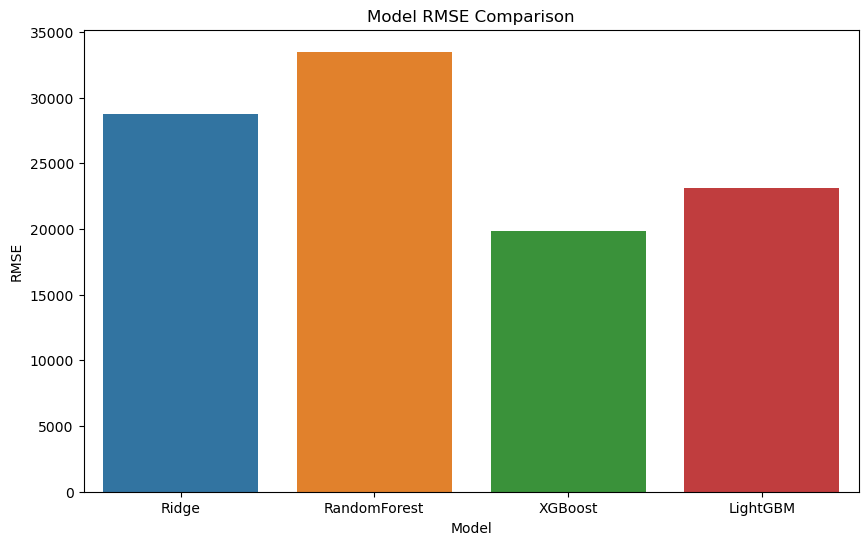

In [10]:
# Visualize the RMSE of each model
plt.figure(figsize=(10,6))
sns.barplot(x='Model', y='RMSE', data=results)
plt.title('Model RMSE Comparison')
plt.ylabel('RMSE')
plt.show()

### Additional Analysis on XGBoost As It is the Best Model

In [11]:
# Retrieve the best parameters and estimator for XGBoost
best_xgb_params = best_params['XGBoost']
best_xgb = best_estimators['XGBoost']

# Predict on the test set using the best XGBoost model
y_pred_xgb = best_xgb.predict(X_test)

# Calculate evaluation metrics
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_xgb:.2f}")
print(f"Mean Squared Error (MSE): {mse_xgb:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb:.2f}")
print(f"R-squared (R2): {r2_xgb:.2f}")

XGBoost Model Performance:
Mean Absolute Error (MAE): 13957.15
Mean Squared Error (MSE): 393044808.43
Root Mean Squared Error (RMSE): 19825.36
R-squared (R2): 0.98


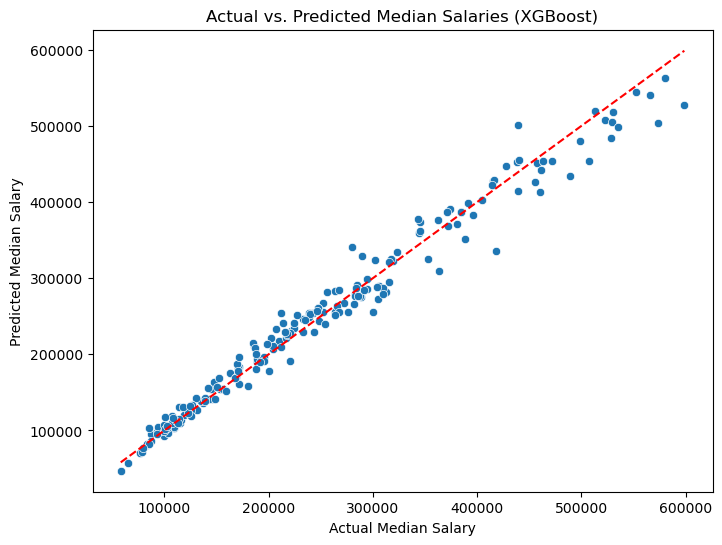

In [12]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred_xgb)
plt.xlabel('Actual Median Salary')
plt.ylabel('Predicted Median Salary')
plt.title('Actual vs. Predicted Median Salaries (XGBoost)')
# Plot a diagonal line for reference
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

/var/folders/pn/7qfxb93s0k9dqkgbt2l7sjgr0000gn/T/ipykernel_78072/2431829329.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, label='Actual', shade=True)
/var/folders/pn/7qfxb93s0k9dqkgbt2l7sjgr0000gn/T/ipykernel_78072/2431829329.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_pred_xgb, label='Predicted', shade=True)


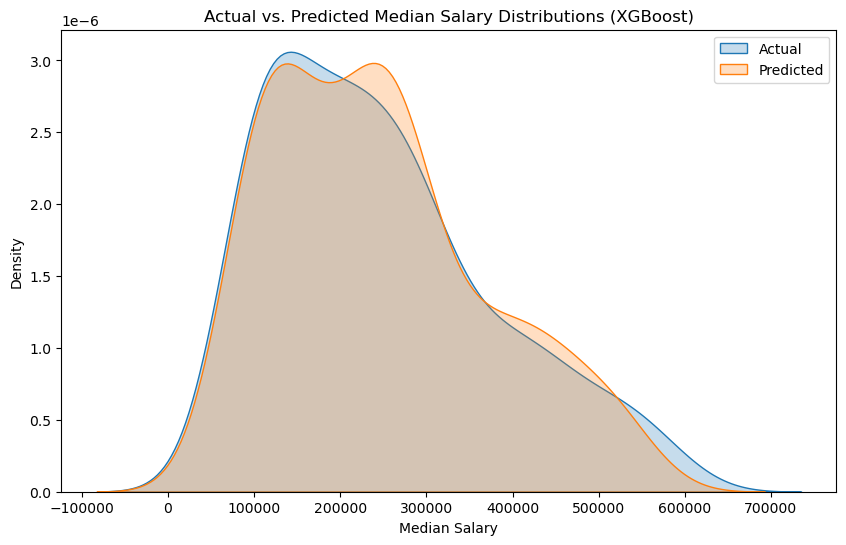

In [18]:
# Compare the actual and predicted med-salary distributions
plt.figure(figsize=(10,6))
sns.kdeplot(y_test, label='Actual', shade=True)
sns.kdeplot(y_pred_xgb, label='Predicted', shade=True)
plt.xlabel('Median Salary')
plt.ylabel('Density')
plt.title('Actual vs. Predicted Median Salary Distributions (XGBoost)')
plt.legend()
plt.show()

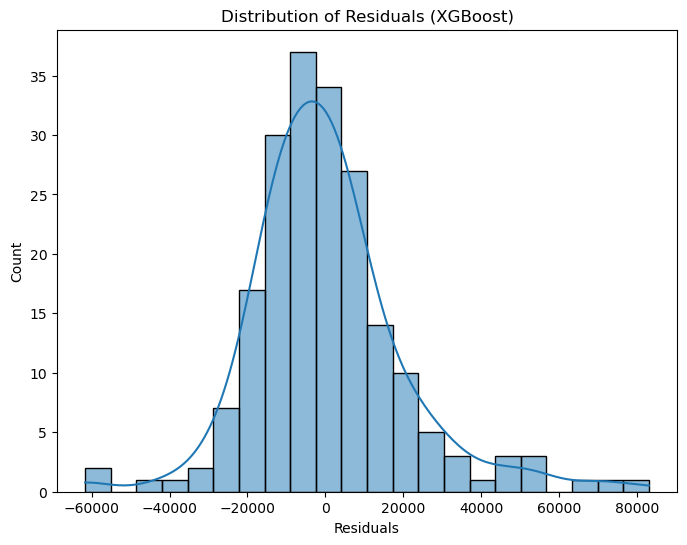

In [13]:
residuals_xgb = y_test - y_pred_xgb

plt.figure(figsize=(8,6))
sns.histplot(residuals_xgb, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals (XGBoost)')
plt.show()

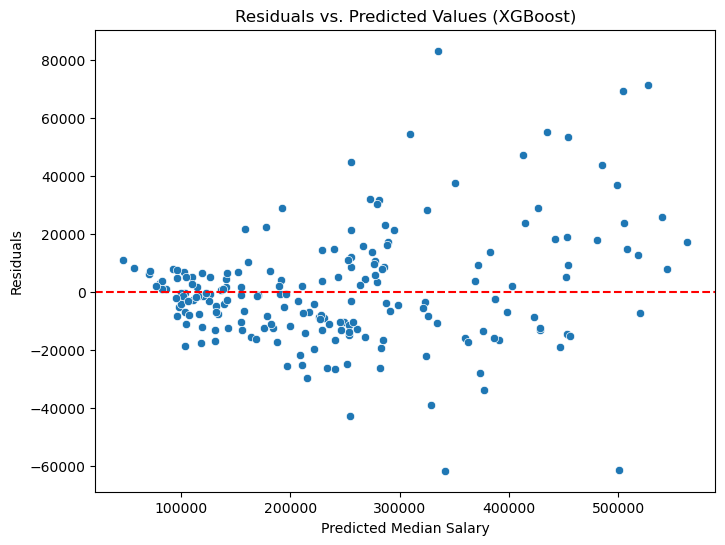

In [14]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred_xgb, y=residuals_xgb)
plt.xlabel('Predicted Median Salary')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values (XGBoost)')
plt.axhline(0, color='red', linestyle='--')
plt.show()

In [15]:
# Get feature names from TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()

# Get feature importances from the XGBoost model
importances = best_xgb.feature_importances_

# Create a DataFrame
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the 10 most important features
print(feature_importance_df.head(10))

        Feature  Importance
38    executive    0.401844
61        level    0.262882
32        entry    0.028275
114  technology    0.025204
59         lead    0.024678
45    francisco    0.023745
70          mid    0.021005
28    education    0.019175
5        austin    0.015920
30     engineer    0.015407


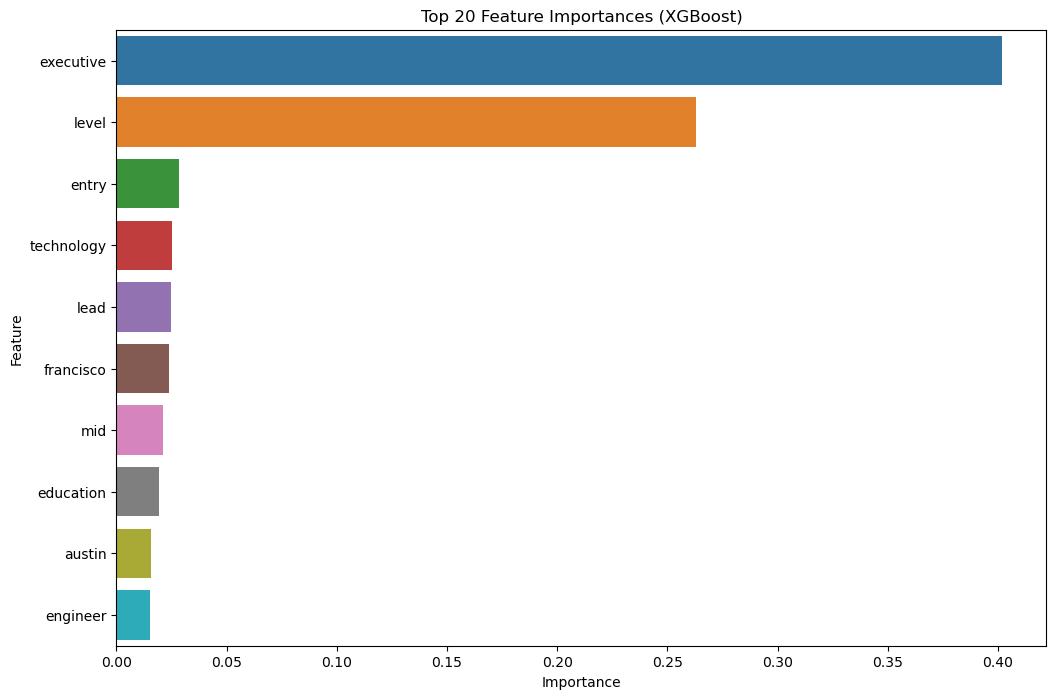

In [16]:
# Visualize the top 10 important features
plt.figure(figsize=(12,8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 20 Feature Importances (XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [17]:
# Add actual and predicted salaries to a DataFrame
results_df = X_test_text.reset_index(drop=True).to_frame()
results_df['Actual_Salary'] = y_test.reset_index(drop=True)
results_df['Predicted_Salary'] = y_pred_xgb
results_df['Residual'] = residuals_xgb.reset_index(drop=True)

# Sort by absolute residuals to find the highest errors
results_df['Abs_Residual'] = results_df['Residual'].abs()
high_error_cases = results_df.sort_values(by='Abs_Residual', ascending=False).head(5)

print("Top 5 High Error Cases:")
print(high_error_cases[['text', 'Actual_Salary', 'Predicted_Salary', 'Residual']])

Top 5 High Error Cases:
                                                  text  Actual_Salary  \
134  Lead Data Scientist San Francisco Exciting opp...     418278.430   
21   Executive HR Generalist San Francisco We are s...     598891.580   
42   Executive HR Generalist New York We are seekin...     573372.145   
66   Executive Customer Success Manager New York Jo...     279534.420   
69   Executive UX Designer San Francisco We are see...     439529.710   

     Predicted_Salary     Residual  
134      335241.53125  83036.89875  
21       527645.37500  71246.20500  
42       504258.78125  69113.36375  
66       341177.43750 -61643.01750  
69       500968.71875 -61439.00875  
